In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [3]:
df = pd.read_csv("AIML Dataset.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.shape

(6362620, 11)

In [5]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [8]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [9]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [10]:
round((df['isFraud'].value_counts()[1] / df.shape[0]) * 100,2)

np.float64(0.13)

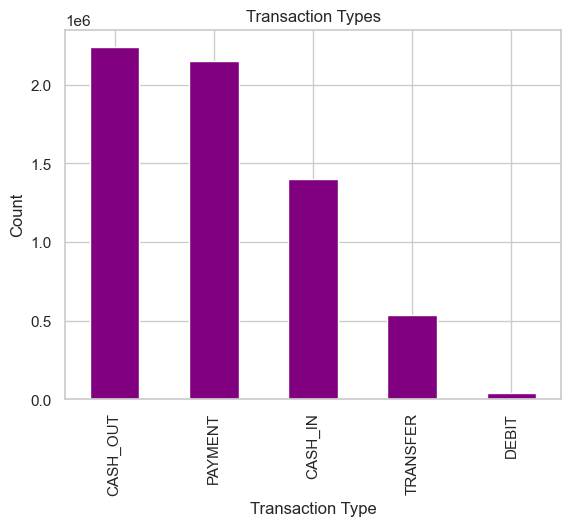

In [11]:
df['type'].value_counts().plot(kind='bar', title='Transaction Types', color ='purple')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

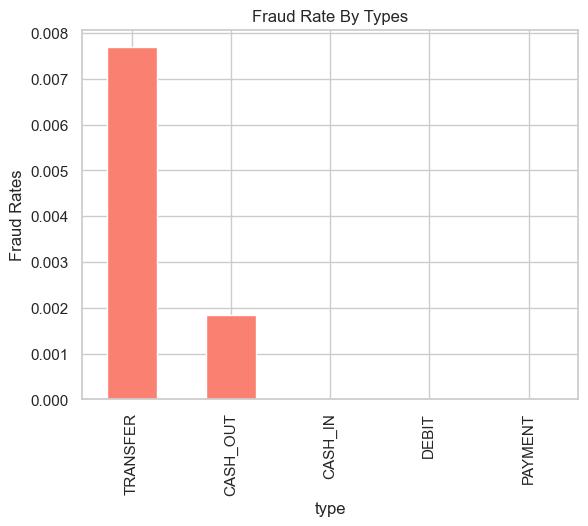

In [12]:
fraud_types = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
fraud_types.plot(kind='bar', title='Fraud Rate By Types', color = 'salmon')
plt.ylabel('Fraud Rates')
plt.show()

In [13]:
df['amount'].describe().astype(int)

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int64

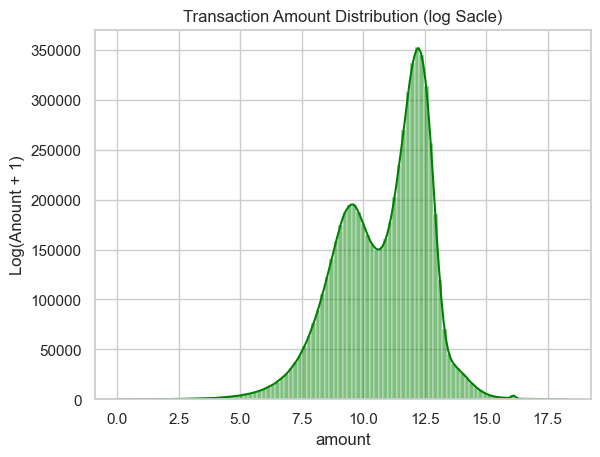

In [14]:
sns.histplot(np.log1p(df['amount']), bins=100, kde=True, color = 'green')
plt.title('Transaction Amount Distribution (log Sacle)')
plt.ylabel('Log(Anount + 1)')
plt.show()

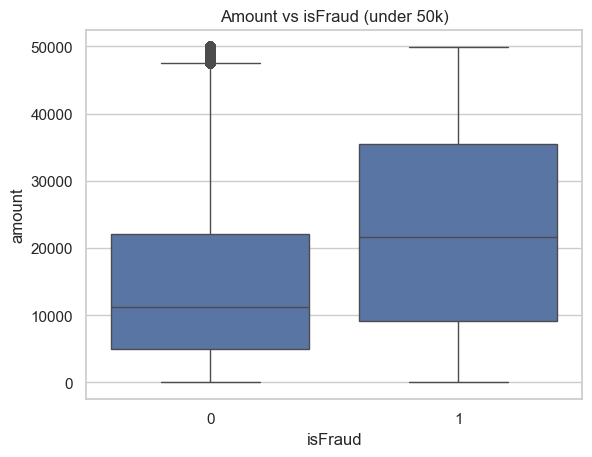

In [15]:
sns.boxplot(data = df[df['amount'] < 50000], x = 'isFraud' , y = 'amount')
plt.title('Amount vs isFraud (under 50k)')
plt.show()

In [16]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [17]:
df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [18]:
(df['balanceDiffOrig'] <0).sum()

np.int64(1399253)

In [19]:
(df['balanceDiffDest'] <0).sum()

np.int64(1238864)

In [20]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


<function matplotlib.pyplot.show(close=None, block=None)>

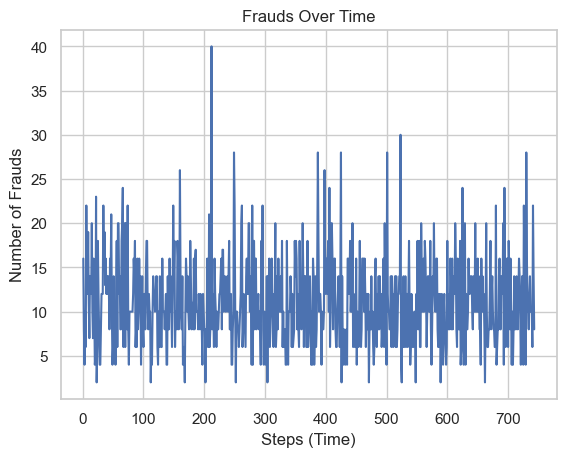

In [21]:
frauds_per_steps = df[df['isFraud'] == 1]['step'].value_counts().sort_index()
plt.plot(frauds_per_steps.index, frauds_per_steps.values, label = 'Frauds per Steps')
plt.xlabel('Steps (Time)')
plt.ylabel('Number of Frauds')
plt.title('Frauds Over Time')
plt.grid(True)
plt.show

In [22]:
df.drop(columns='step', inplace=True)

In [23]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [24]:
top_senders = df['nameOrig'].value_counts().head()
top_senders

nameOrig
C1677795071    3
C1999539787    3
C724452879     3
C1976208114    3
C400299098     3
Name: count, dtype: int64

In [25]:
top_recivers = df['nameDest'].value_counts().head()
top_recivers

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
Name: count, dtype: int64

In [26]:
fraud_users = df[df['isFraud'] == 1]['nameOrig'].value_counts().head(10)
fraud_users


nameOrig
C1280323807    1
C1305486145    1
C840083671     1
C1420196421    1
C2101527076    1
C1039979813    1
C2089752665    1
C1614818636    1
C40604503      1
C1970706589    1
Name: count, dtype: int64

In [27]:
fraud_types = df[df['type'].isin(['TRANSFER','CASH_OUT'])]
fraud_types['type'].value_counts()

type
CASH_OUT    2237500
TRANSFER     532909
Name: count, dtype: int64

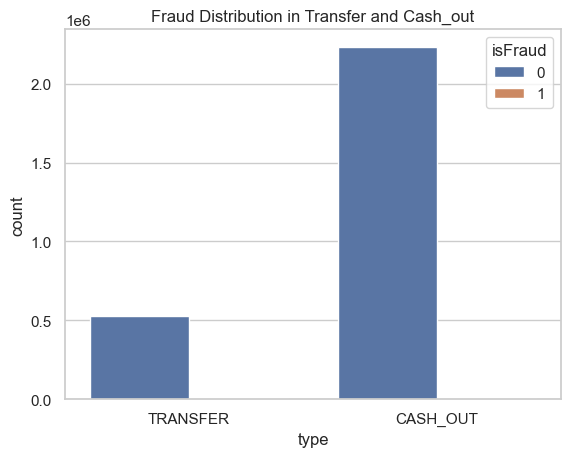

In [28]:
sns.countplot(data = fraud_types, x = 'type', hue = 'isFraud')
plt.title('Fraud Distribution in Transfer and Cash_out')
plt.show()

In [29]:
corr = df[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud']].corr()

In [30]:
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


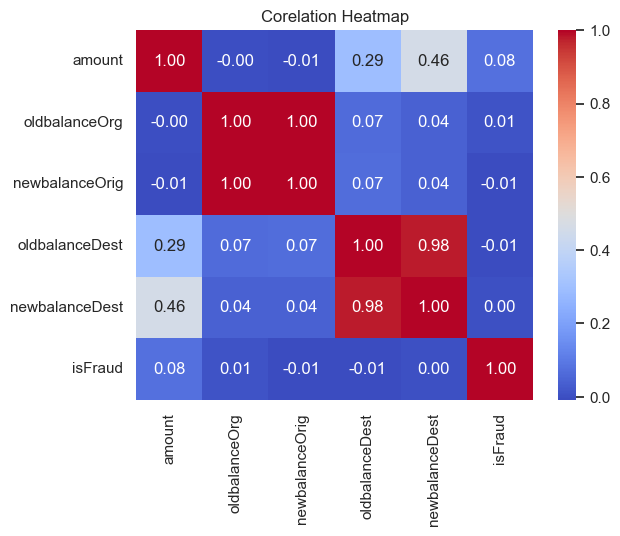

In [31]:
sns.heatmap(corr, annot=True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Corelation Heatmap')
plt.show()

In [32]:
zero_aft_transfer = df[
    (df['oldbalanceOrg'] > 0) &
    (df['newbalanceOrig'] == 0) &
    (df['type'].isin(['TRANSFER','CASH_OUT']))
]

In [33]:
len(zero_aft_transfer)

1188074

In [34]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [35]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [37]:
df_model = df.drop(['nameOrig','nameDest','isFlaggedFraud'], axis= 1)
df_model.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,9839.64,0.0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,1864.28,0.0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,181.00,0.0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,181.00,-21182.0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,11668.14,0.0


In [38]:
categorical = ['type']
numercial = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

In [39]:
y = df_model['isFraud']
x = df_model.drop('isFraud', axis = 1)

In [40]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, stratify=y)

In [41]:
preprocessor = ColumnTransformer(
    transformers= [
        ('num',StandardScaler(), numercial),
        ('cat', OneHotEncoder(drop='first'), categorical)
    ],
    remainder='drop'
)

In [42]:
pipeline = Pipeline([
    ('prep',preprocessor),
    ('clf', LogisticRegression(class_weight='balanced',max_iter=1000))
])

In [43]:
pipeline.fit(x_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [46]:
y_pred = pipeline.predict(x_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(1908786,))

In [47]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.94      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



In [48]:
confusion_matrix(y_test,y_pred)

array([[1802399,  103923],
       [    147,    2317]])

In [50]:
pipeline.score(x_test,y_test) * 100

94.54784349843304

In [53]:
joblib.dump(pipeline,'Fraud_detection_pipeline.pkl')

['Fraud_detection_pipeline.pkl']